In [1]:
import cx_Oracle as ora
import os
from configparser import ConfigParser

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance

from lightgbm import LGBMClassifier
from catboost import Pool,CatBoostClassifier
from sklearn.linear_model import LogisticRegression


import sklearn
from sklearn.metrics import f1_score, roc_auc_score, fbeta_score, recall_score, precision_score, precision_recall_curve, auc,cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline

import category_encoders as ce

import optuna
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour, ClusterCentroids, RandomUnderSampler
from imblearn.metrics import geometric_mean_score

from tqdm import tqdm

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from src import utils as ut

import pickle
import pyarrow.parquet as pq
import pyarrow as pa

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
df_new = pd.read_parquet('../data/osg_em_df_prepared_with_clients_feat_21_03.parquet')

In [3]:
df_new[df_new.TARGET==0].shape[0]

28826

In [4]:
df_new.shape[0]

29110

In [5]:
df_new[df_new.TARGET >0].shape[0]

284

In [6]:
drop_list = ['OBSDATE','CLIENTISN','TARGET']

In [7]:
X = df_new.drop(columns=drop_list)
y = df_new[['TARGET']]

In [8]:
# positive = df_new[df_new.TARGET==1]
# negative = df_new[df_new.TARGET==0].sample(n=len(df_new[df_new.TARGET==1])*5, random_state=123)
# df = pd.concat([positive, negative])

# X = df.drop(columns=drop_list)
# y = df[['TARGET']]

# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=123)
# X_resampled, y_resampled = ros.fit_resample(X, y)
# X_resampled['TARGET'] = y_resampled

# positive = X_resampled[X_resampled.TARGET==1]
# negative = df_new[df_new.TARGET==0].sample(n=len(df_new[df_new.TARGET==0])//3, random_state=123)
# df_new = pd.concat([positive, negative])

In [9]:
df_new.shape[0]

29110

In [10]:
df_new[df_new.TARGET >0].shape[0]

284

In [11]:
df_new = pd.read_parquet('../data/osg_em_df_prepared_with_clients_feat_21_03.parquet')

In [12]:
drop_list = ['OBSDATE','CLIENTISN','TARGET']

In [13]:
X = df_new.drop(columns=drop_list)
y = df_new[['TARGET']]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [15]:
w = y_train[y_train.TARGET == 0].shape[0]/y_train[y_train.TARGET == 1].shape[0]

In [16]:
w

102.96428571428571

In [17]:
data= pd.DataFrame(columns=['Iteration', 'Roc_auc_train', 'Roc_auc_test'])

w = y_train[y_train.TARGET == 0].shape[0]/y_train[y_train.TARGET == 1].shape[0]
for its in range(1, 51, 2):
    new_row = {}
    baseline_model = CatBoostClassifier(loss_function='Logloss',eval_metric='WKappa',class_weights={0: 1.0, 1: w},iterations=its)
    baseline_model.fit(X_train, y_train)

    new_row['Iteration'] =its
    new_row['Roc_auc_train'] = roc_auc_score(y_train,  baseline_model.predict(X_train))
    new_row['Roc_auc_test'] = roc_auc_score(y_test,  baseline_model.predict(X_test))
    data = data.append(new_row,ignore_index=True)

Learning rate set to 0.5
0:	learn: 0.6251750	total: 168ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6251750	total: 24.3ms	remaining: 48.7ms
1:	learn: 0.7277421	total: 48.3ms	remaining: 24.2ms
2:	learn: 0.7505853	total: 70.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6251750	total: 24.2ms	remaining: 96.8ms
1:	learn: 0.7277421	total: 49.2ms	remaining: 73.7ms
2:	learn: 0.7505853	total: 71.5ms	remaining: 47.6ms
3:	learn: 0.7682272	total: 94.3ms	remaining: 23.6ms
4:	learn: 0.8071562	total: 119ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6251750	total: 25.3ms	remaining: 152ms
1:	learn: 0.7277421	total: 49.5ms	remaining: 124ms
2:	learn: 0.7505853	total: 71.5ms	remaining: 95.4ms
3:	learn: 0.7682272	total: 94.2ms	remaining: 70.6ms
4:	learn: 0.8071562	total: 119ms	remaining: 47.6ms
5:	learn: 0.8341649	total: 142ms	remaining: 23.7ms
6:	learn: 0.8335161	total: 165ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6251750	total: 24.3ms	remaining: 195ms
1:	learn: 0

17:	learn: 0.9253382	total: 416ms	remaining: 162ms
18:	learn: 0.9268991	total: 440ms	remaining: 139ms
19:	learn: 0.9305411	total: 463ms	remaining: 116ms
20:	learn: 0.9370881	total: 486ms	remaining: 92.6ms
21:	learn: 0.9431148	total: 512ms	remaining: 69.8ms
22:	learn: 0.9469303	total: 535ms	remaining: 46.5ms
23:	learn: 0.9506590	total: 558ms	remaining: 23.2ms
24:	learn: 0.9557319	total: 580ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6251750	total: 24.5ms	remaining: 636ms
1:	learn: 0.7277421	total: 48.2ms	remaining: 603ms
2:	learn: 0.7505853	total: 70.1ms	remaining: 561ms
3:	learn: 0.7682272	total: 92.5ms	remaining: 532ms
4:	learn: 0.8071562	total: 117ms	remaining: 516ms
5:	learn: 0.8341649	total: 140ms	remaining: 488ms
6:	learn: 0.8335161	total: 162ms	remaining: 463ms
7:	learn: 0.8436617	total: 184ms	remaining: 438ms
8:	learn: 0.8526352	total: 208ms	remaining: 417ms
9:	learn: 0.8705373	total: 231ms	remaining: 393ms
10:	learn: 0.8841051	total: 254ms	remaining: 369ms
11:	learn:

Learning rate set to 0.5
0:	learn: 0.6251750	total: 25.4ms	remaining: 914ms
1:	learn: 0.7277421	total: 49.6ms	remaining: 869ms
2:	learn: 0.7505853	total: 71.8ms	remaining: 814ms
3:	learn: 0.7682272	total: 94.5ms	remaining: 779ms
4:	learn: 0.8071562	total: 119ms	remaining: 762ms
5:	learn: 0.8341649	total: 141ms	remaining: 730ms
6:	learn: 0.8335161	total: 164ms	remaining: 703ms
7:	learn: 0.8436617	total: 186ms	remaining: 675ms
8:	learn: 0.8526352	total: 209ms	remaining: 651ms
9:	learn: 0.8705373	total: 232ms	remaining: 626ms
10:	learn: 0.8841051	total: 255ms	remaining: 603ms
11:	learn: 0.8881807	total: 278ms	remaining: 579ms
12:	learn: 0.8886158	total: 299ms	remaining: 553ms
13:	learn: 0.9027055	total: 323ms	remaining: 530ms
14:	learn: 0.9139785	total: 347ms	remaining: 509ms
15:	learn: 0.9204821	total: 370ms	remaining: 486ms
16:	learn: 0.9225199	total: 393ms	remaining: 463ms
17:	learn: 0.9253382	total: 417ms	remaining: 440ms
18:	learn: 0.9268991	total: 441ms	remaining: 418ms
19:	learn: 0

Learning rate set to 0.5
0:	learn: 0.6251750	total: 24.3ms	remaining: 1.07s
1:	learn: 0.7277421	total: 48.9ms	remaining: 1.05s
2:	learn: 0.7505853	total: 71ms	remaining: 995ms
3:	learn: 0.7682272	total: 93.8ms	remaining: 961ms
4:	learn: 0.8071562	total: 119ms	remaining: 950ms
5:	learn: 0.8341649	total: 141ms	remaining: 916ms
6:	learn: 0.8335161	total: 164ms	remaining: 889ms
7:	learn: 0.8436617	total: 187ms	remaining: 864ms
8:	learn: 0.8526352	total: 211ms	remaining: 842ms
9:	learn: 0.8705373	total: 235ms	remaining: 821ms
10:	learn: 0.8841051	total: 258ms	remaining: 796ms
11:	learn: 0.8881807	total: 280ms	remaining: 771ms
12:	learn: 0.8886158	total: 302ms	remaining: 744ms
13:	learn: 0.9027055	total: 325ms	remaining: 721ms
14:	learn: 0.9139785	total: 349ms	remaining: 699ms
15:	learn: 0.9204821	total: 373ms	remaining: 676ms
16:	learn: 0.9225199	total: 396ms	remaining: 652ms
17:	learn: 0.9253382	total: 420ms	remaining: 630ms
18:	learn: 0.9268991	total: 443ms	remaining: 607ms
19:	learn: 0.9

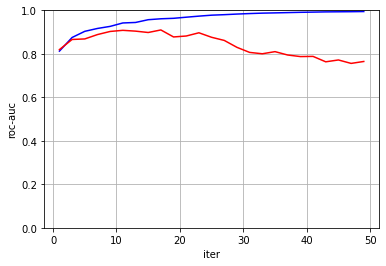

In [18]:
fig, ax = plt.subplots()
ax.plot(data.Iteration, data.Roc_auc_train ,color='blue')
ax.plot(data.Iteration, data.Roc_auc_test ,color='red')

ax.set(xlabel='iter', ylabel='roc-auc')
ax.set_ylim([0, 1])
ax.grid()

plt.show()

In [19]:
baseline_model = CatBoostClassifier(loss_function='Logloss',eval_metric='WKappa',class_weights={0: 1.0, 1: w},iterations=10)
baseline_model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.6251750	total: 24.9ms	remaining: 224ms
1:	learn: 0.7277421	total: 49.4ms	remaining: 198ms
2:	learn: 0.7505853	total: 71.6ms	remaining: 167ms
3:	learn: 0.7682272	total: 94.3ms	remaining: 141ms
4:	learn: 0.8071562	total: 119ms	remaining: 119ms
5:	learn: 0.8341649	total: 142ms	remaining: 94.5ms
6:	learn: 0.8335161	total: 165ms	remaining: 70.9ms
7:	learn: 0.8436617	total: 188ms	remaining: 47.1ms
8:	learn: 0.8526352	total: 212ms	remaining: 23.5ms
9:	learn: 0.8705373	total: 234ms	remaining: 0us


In [20]:
df_fi = pd.DataFrame({'feature_importance': baseline_model.get_feature_importance(), 
              'feature_names': df_new.drop(columns=drop_list).columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False, ignore_index = True)

In [21]:
sum_fi =0
count_feat = 0
for i in range(df_fi.shape[0]):
    count_feat+=1
    sum_fi += df_fi.iloc[i].feature_importance
    if sum_fi > 92:
        break;
        
        
print(sum_fi,count_feat)

92.93362636572574 23


<AxesSubplot:ylabel='feature_names'>

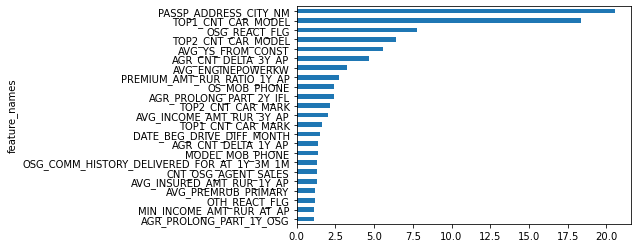

In [23]:
df_fi.head(23).groupby('feature_names')['feature_importance'].sum().sort_values().plot.barh()

In [24]:
feat_for_std = df_fi.head(23).feature_names.values

In [25]:
feat_for_std

array(['PASSP_ADDRESS_CITY_NM', 'TOP1_CNT_CAR_MODEL', 'OSG_REACT_FLG',
       'TOP2_CNT_CAR_MODEL', 'AVG_YS_FROM_CONST', 'AGR_CNT_DELTA_3Y_AP',
       'AVG_ENGINEPOWERKW', 'PREMIUM_AMT_RUR_RATIO_1Y_AP', 'OS_MOB_PHONE',
       'AGR_PROLONG_PART_2Y_IFL', 'TOP2_CNT_CAR_MARK',
       'AVG_INCOME_AMT_RUR_3Y_AP', 'TOP1_CNT_CAR_MARK',
       'DATE_BEG_DRIVE_DIFF_MONTH', 'AGR_CNT_DELTA_1Y_AP',
       'MODEL_MOB_PHONE', 'OSG_COMM_HISTORY_DELIVERED_FOR_AT_1Y_3M_1M',
       'CNT_OSG_AGENT_SALES', 'AVG_INSURED_AMT_RUR_1Y_AP',
       'AVG_PREMRUB_PRIMARY', 'OTH_REACT_FLG', 'MIN_INCOME_AMT_RUR_AT_AP',
       'AGR_PROLONG_PART_1Y_OSG'], dtype=object)

In [26]:
feat_for_std = ['PASSP_ADDRESS_CITY_NM', 'TOP1_CNT_CAR_MODEL', 'OSG_REACT_FLG',
       'TOP2_CNT_CAR_MODEL', 'AVG_YS_FROM_CONST', 'AGR_CNT_DELTA_3Y_AP',
       'AVG_ENGINEPOWERKW', 'PREMIUM_AMT_RUR_RATIO_1Y_AP', 'OS_MOB_PHONE',
       'AGR_PROLONG_PART_2Y_IFL', 'TOP2_CNT_CAR_MARK',
       'AVG_INCOME_AMT_RUR_3Y_AP', 'TOP1_CNT_CAR_MARK',
       'DATE_BEG_DRIVE_DIFF_MONTH', 'AGR_CNT_DELTA_1Y_AP',
       'MODEL_MOB_PHONE', 'OSG_COMM_HISTORY_DELIVERED_FOR_AT_1Y_3M_1M',
       'CNT_OSG_AGENT_SALES', 'AVG_INSURED_AMT_RUR_1Y_AP',
       'AVG_PREMRUB_PRIMARY', 'OTH_REACT_FLG', 'MIN_INCOME_AMT_RUR_AT_AP',
       'AGR_PROLONG_PART_1Y_OSG']

# Tuning

In [27]:
# X_train, X_test, y_train, y_test

In [28]:
import json
import itertools
from tqdm import tqdm
 
 
def grid_gen(param_grid):
  """
  полчение сетки параметров для обучения
  """
 
  grid = list(itertools.product(*(param_grid[i] for i in param_grid.keys())))
  df = pd.DataFrame(data=grid, columns = param_grid.keys())
  return df

In [29]:
def train_model(param_grid,
                STAGE_NUM,
                df_train=X_train[feat_for_std],
                df_test=X_test[feat_for_std],
                target_train=y_train.TARGET,
                target_test=y_test.TARGET
                ):
    """
    обучение CatBoost по сетке
    """
 
    # метрики на наборе параметров  
    # list_net_loss_train = []
    # list_net_loss_test = []
 
    # метрики на итерации обучения
    list_of_df = []
 
    grid_df = grid_gen(param_grid)
    params = grid_df.to_json(orient='records')
    params = json.loads(params)
 
    grid_df.reset_index(inplace=True)
    grid_df.rename(columns={'index': 'param_set'}, inplace=True)
 
    print("Перебор гиперпараметров")
   
    for i in tqdm(range(len(params))):
        model = CatBoostClassifier(
            **params[i],
            # task_type="GPU",
            loss_function='Logloss',
            eval_metric='WKappa'
        )
 
        model.fit(
            df_train,
            target_train,
            eval_set=(df_test, target_test),
            # verbose=True
            verbose=False
        )
 
       
        # метрики на наборе параметров  
        # y_pred_train = pd.DataFrame(model.predict_proba(df_train))
        # y_pred_test = pd.DataFrame(model.predict_proba(df_test))
       
        # # кастомная
        # list_net_loss_train.append(_net_loss(df_train, y_pred_train))
        # list_net_loss_test.append(_net_loss(df_test, y_pred_test))
 
        # метрики на итерации обучения
        df_evals = pd.DataFrame()
       
        df_evals['learn_Logloss'] = model.evals_result_['learn']['Logloss']
        df_evals['validation_Logloss'] = model.evals_result_['validation']['Logloss']
        df_evals['learn_WKappa'] = model.evals_result_['learn']['WKappa']
        df_evals['validation_WKappa'] = model.evals_result_['validation']['WKappa']
 
        df_evals['param_set'] = i # номер набора параметров
 
        df_evals.reset_index(inplace=True)
        df_evals.rename(columns={'index': 'iteration_on_set'}, inplace=True)
 
        list_of_df.append(df_evals) # сохраняем промежуточные итерации (TODO: мб в паркет, а то память не бесконечна ??? )
   
   
    print('запись метрик')
    # grid_df['FINAL_net_loss_TRAIN'] = list_net_loss_train
    # grid_df['FINAL_net_loss_TEST'] = list_net_loss_test
 
    print('Join параметров и метрик')
    df_merge = pd.concat(list_of_df, ignore_index= True )
    grid_df = grid_df.merge(df_merge, on='param_set', how='left')  
   
    print('Сохранение в csv: ' + f'stage_{STAGE_NUM}_pc_model_train.csv')
    grid_df.to_csv(f'stage_{STAGE_NUM}_pc_model_train.csv')
 
    print('Сохранение в excel: ' + f'stage_{STAGE_NUM}_pc_model_train.xlsx')
    grid_df.to_excel(f'stage_{STAGE_NUM}_pc_model_train.xlsx')

In [36]:
STAGE_NUM = 0
 
param_grid_test = {
        'learning_rate': np.arange(0.05, 0.35, 0.05),
        'depth': range(2,10,2),
        'iterations': [10],
        'scale_pos_weight': range(98, 105, 1)          
            }

In [39]:
STAGE_NUM = 1
 
param_grid_test = {
        'learning_rate': np.arange(0.15, 0.25, 0.01),
        'depth': range(3,9,1),
        'iterations': range(5,11,1),
        'scale_pos_weight': np.arange(98, 101, 0.1)          
            }

In [40]:
train_model(param_grid_test, STAGE_NUM)

Перебор гиперпараметров


100%|████████████████████████████████████████████████████████████████████████████| 10800/10800 [25:46<00:00,  6.99it/s]


запись метрик
Join параметров и метрик
Сохранение в csv: stage_1_pc_model_train.csv
Сохранение в excel: stage_1_pc_model_train.xlsx


# Learn bst model

In [41]:
df_new = pd.read_parquet('../data/osg_em_df_prepared_with_clients_feat_21_03.parquet')

In [42]:
drop_list = ['OBSDATE','CLIENTISN','TARGET']

In [43]:
X = df_new[feat_for_std]
y = df_new[['TARGET']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [45]:
bst_param = {
        'learning_rate': 0.21,
        'depth': 8,
        'iterations': 9,
        'scale_pos_weight': 100.6,
        'loss_function':'Logloss',
        'eval_metric':'WKappa'
            }

In [46]:
bst_model = CatBoostClassifier(**bst_param)

In [47]:
bst_model.fit(X_train[feat_for_std], y_train)

0:	learn: 0.7018197	total: 10.5ms	remaining: 83.7ms
1:	learn: 0.7294274	total: 25.1ms	remaining: 87.9ms
2:	learn: 0.7622619	total: 40.6ms	remaining: 81.1ms
3:	learn: 0.7871849	total: 55.4ms	remaining: 69.3ms
4:	learn: 0.8239651	total: 70.2ms	remaining: 56.1ms
5:	learn: 0.8339374	total: 84.4ms	remaining: 42.2ms
6:	learn: 0.8391416	total: 94.6ms	remaining: 27ms
7:	learn: 0.8434267	total: 111ms	remaining: 13.9ms
8:	learn: 0.8618785	total: 126ms	remaining: 0us


In [48]:
X_val = X_train
y_val = y_train

In [49]:
predict_val = bst_model.predict(X_val)
rec_val=recall_score(y_val, predict_val)
pre_val=precision_score(y_val, predict_val,)
f1_val=f1_score(y_val, predict_val)
f1_2_val = fbeta_score(y_val, predict_val, beta=0.5)
roc_auc_val = roc_auc_score(y_val, bst_model.predict(X_val))
rec_val=np.round(rec_val, 4) 
pre_val=np.round(pre_val, 4)  
f1_val=np.round(f1_val , 4)
f1_2_val=np.round(f1_2_val , 4) 
roc_auc_val=np.round(roc_auc_val , 4) 
print('recall:   ',rec_val ,'precision:   ',pre_val ,'f1:   ',f1_val 
      ,'f1/2:     ',f1_2_val ,'roc auc:     ',roc_auc_val )

recall:    0.9821 precision:    0.0741 f1:    0.1378 f1/2:      0.0909 roc auc:      0.9315


In [50]:
X_val = X_test
y_val = y_test

In [51]:
predict_val = bst_model.predict(X_val)
rec_val=recall_score(y_val, predict_val)
pre_val=precision_score(y_val, predict_val,)
f1_val=f1_score(y_val, predict_val)
f1_2_val = fbeta_score(y_val, predict_val, beta=0.5)
roc_auc_val = roc_auc_score(y_val, bst_model.predict(X_val))
rec_val=np.round(rec_val, 4) 
pre_val=np.round(pre_val, 4)  
f1_val=np.round(f1_val , 4)
f1_2_val=np.round(f1_2_val , 4) 
roc_auc_val=np.round(roc_auc_val , 4) 
print('recall:   ',rec_val ,'precision:   ',pre_val ,'f1:   ',f1_val 
      ,'f1/2:     ',f1_2_val ,'roc auc:     ',roc_auc_val )

recall:    0.95 precision:    0.0769 f1:    0.1423 f1/2:      0.0942 roc auc:      0.9156


In [52]:
print(X_train.shape[0],X_test.shape[0])

23288 5822


In [53]:
y_train[y_train.TARGET >0].shape[0]

224

In [54]:
y_test[y_test.TARGET >0].shape[0] 

60

In [55]:
with open('igs_life_model.pickle', 'wb') as f:
    pickle.dump(bst_model, f)